# Description
This notebook will tackle the following areas
-  Installing custom packages
-  Importing packages and defining functions
-  Show plots
-  Calculating the weights as is done in original U-Net paper
    -  https://arxiv.org/pdf/1505.04597.pdf

<br>
In essence, our goal is to generate the colored image from the BW image
<br>
<img style="float: left" src="./data/unet_text.png"><img style="float: left" src="./data/unet_example.png">

# 1. Requirements
Google datalab comes equipped with a number of pre-installad packages and is often enough for general data analysis purposes.
<br>However, in this notebook we need to install opencv. We do this by using the $!$ flag, which symply runs the command in a shell.

After running this cell, you can hide the output by clicking on the output and pressing the letter O on your keyboard.

In [1]:
!apt-get install gnupg
!apt-get update
!apt-get --allow-unauthenticated -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install tqdm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gnupg is already the newest version (1.4.20-1ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Get:1 http://archive.ubuntu.com/ubuntu xenial InRelease [247 kB]
Get:2 http://security.ubuntu.com/ubuntu xenial-security InRelease [102 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [102 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [102 kB]
Ign:1 http://archive.ubuntu.com/ubuntu xenial InRelease
Ign:3 http://archive.ubuntu.com/ubuntu xenial-updates InRelease
Ign:2 http://security.ubuntu.com/ubuntu xenial-security InRelease
Ign:4 http://archive.ubuntu.com/ubuntu xenial-backports InRelease
Get:5 http://archive.ubuntu.com/ubuntu xenial/universe Sources [9,802 kB]
Get:6 http://ftp.us.debian.org/debian testing InRelease [142 kB]
Get:7 http://security.ubuntu.com/ubuntu xenial-security/universe Sources [58.3 kB]
Get:8 http://security.

# 2. Import and define
Now we import the necessary libraries for this notebook. I also create a helper function that plots our images from an array.

In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Get example image
example_label = './data/unet_example_only.png'

# Define a figure function
def show_fig(img, cmap=None):
  fig = plt.figure(figsize = (10,10))
  ax = plt.subplot(111)
  divider = make_axes_locatable(ax)
  if cmap is not None:
    im = ax.imshow(img, cmap=cmap)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
  else:
    im = ax.imshow(img)
  ax.grid(False)
  plt.show()


## 2.1 Testing
Let's test our plot function and our ability of detecting the contours of the cells.<br>
We take the image from the u-net paper and load it with opencv. There is one caveat as the image is a screen capture from the paper, so we need to apply some thresholding to capture the black color between the cells.

Found 14 contours


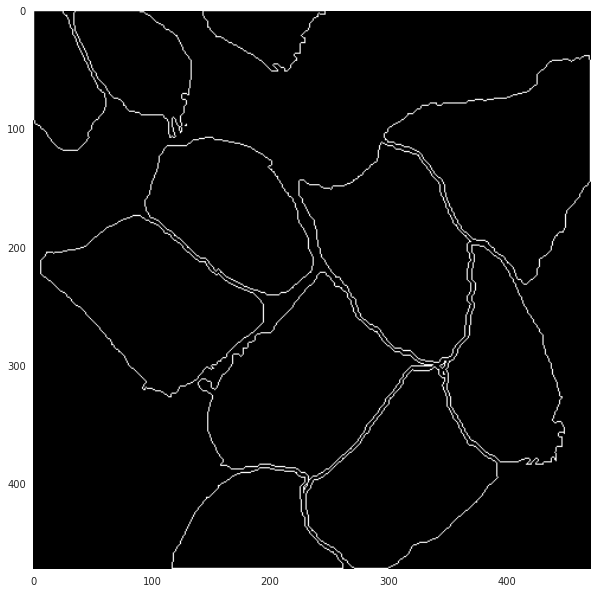

In [2]:
# Read the image in black and white
img = cv2.imread(example_label, cv2.IMREAD_GRAYSCALE)
ret, img = cv2.threshold(img, 200,255, cv2.THRESH_BINARY)

shape = list(img.shape) + [3]
img_empty = 255*np.ones(img.shape, dtype=np.uint8)

# Calculate the contours
_, contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Found %d contours" % len(contours))

# Draw them onto the rgb image
img_contours = cv2.drawContours(img_empty.copy(), contours, -1, (0, 0), -1)
img_contours_only = cv2.drawContours(img_empty.copy(), contours, -1, (0, 0), 1)

# Plot
show_fig(img_contours_only)

As you can see, it's quite easy and fast to detect the contours from a black and white blob image.

# 2.2 Calculate distance from all pixels to a single contour
The core idea behind the weight image, is to calculate the closest boundary of any pixel. To do this, we calculate the distance from all pixels to all the contours.<br>
Scipy has a very nice method called distance_transform_edt which does exactly that, it calculates the euclidean distance for any "zeros" in an array to the closest "one"

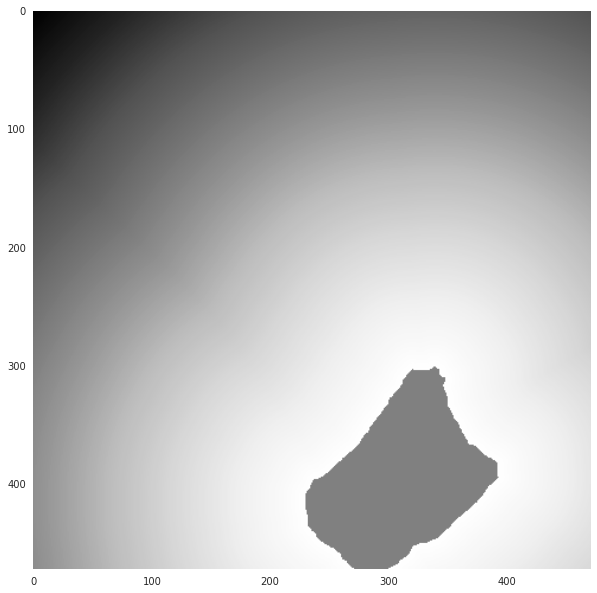

In [4]:
import scipy.ndimage as ndimage
this_contour_test = cv2.drawContours(img_empty.copy(), [contours[2]], -1, (0, 0), -1)
edt = ndimage.distance_transform_edt(this_contour_test == 255) - this_contour_test
show_fig(edt)

The more white, the closer the pixel to a boundary. I removed the white color of the cell in question so that it is more clear which cell it is.

# 2.3 Calculate distance map of all contours
Now that we decided on a method, we do the same to __all__ contours, and save the generated distance array.
Remember that our goal is
```python
for i_pixel in background_pixels:
    d_1 = closest_boundary_distance(i_pixel)
    d_2 = second_closest_boundary_distance(i_pixel)
```
But we of course use a more vectorized way of doing this.<br>
We first get the index along the 2 dimension of the minimum values, these are the locations of the d_1. Then at those locations, after collecting the values, we set the value to the highest possible value, then get the minimum value again, which now will be the second smallest distance.

100%|██████████| 14/14 [00:00<00:00, 67.12it/s]


The shape the array is: (472, 471, 14)


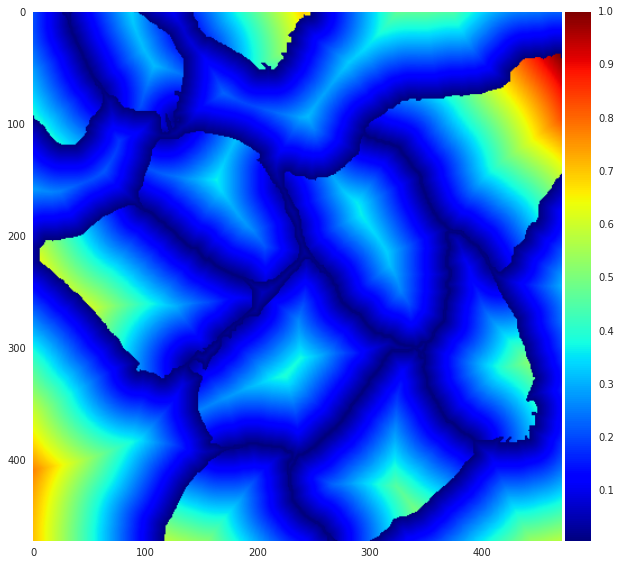

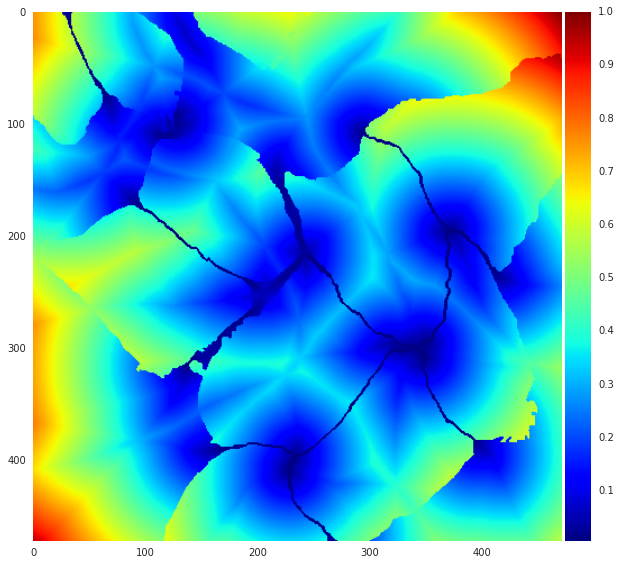

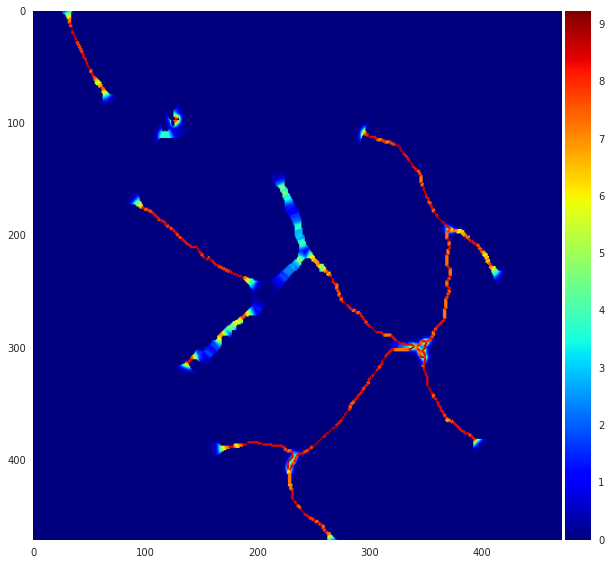

In [5]:
import scipy.ndimage as ndimage
from tqdm import tqdm

img_empty = 255 * np.ones(img.shape, dtype=np.uint8)
collected_edt = []
for i_contour in tqdm(contours):
  this_contour = cv2.drawContours(img_empty.copy(), [i_contour], -1, (0, 0), -1)
  edt = ndimage.distance_transform_edt(this_contour == 255)
  collected_edt.append(edt)

# Stack our list of images into an array
distance_map = np.stack(collected_edt, -1)
print("The shape the array is: {}".format(distance_map.shape))

largest_distance = distance_map.max() + 1

# Anywhere where there is zero, we set to the largest number
distance_map[distance_map == 0] = largest_distance

# Calculate closest and next closest cell to all pixels
_idx = np.meshgrid(*[np.arange(dim) for dim in img.shape])
row_idx, col_idx = [idx.transpose() for idx in _idx]
cell_idx = np.argmin(distance_map, -1)
d1_val = distance_map[row_idx, col_idx, cell_idx]
distance_map[row_idx, col_idx, cell_idx] = largest_distance + 1
d2_val = np.min(distance_map, -1)

def get_weight_map(d1, d2, w0=10, sigma=5):
  return w0 * np.exp(-np.divide(np.power(d1_val + d2_val, 2), 2 * sigma**2))

show_fig(d1_val / d1_val.max(), cmap='jet')
show_fig(d2_val / d2_val.max(), cmap='jet')
weight_map = get_weight_map(d1_val, d2_val)
show_fig(weight_map, cmap='jet')

Excellent! Our image has started to look alot like our goal image. It clearly has high weight where cells are close together.
Now, the paper also use class weighting on-top of this. Basically it calculates the ratio of cell pixels vs background pixels and applies them as weights. <br>
Lets try the same thing as above, and add the class ratio weights.

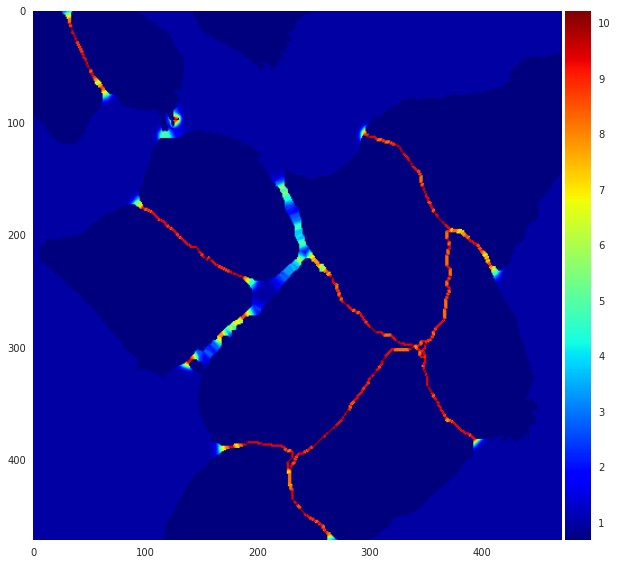

In [6]:
# As a complete function
from PIL import Image
import cv2
import numpy as np
import scipy.ndimage as ndimage
import os

def get_weight_array(image_path, w0=10, sigma=5):

  # Read the image
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  _, img = cv2.threshold(img, 200,255, cv2.THRESH_BINARY)

  # Calculate the contours
  img_empty = 255 * np.ones(img.shape, dtype=np.uint8)
  _, contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  # Draw them onto the rgb image
  all_contours_together = cv2.drawContours(img_empty.copy(), contours, -1, (0, 0), -1)
  
  # Create an empty container to fill in
  distance_map = np.zeros(list(img.shape) + [len(contours)])
  
  # Loop through all contours
  for i, i_contour in enumerate(contours):
    this_contour = cv2.drawContours(img_empty.copy(), [i_contour], -1, (0, 0), -1)
    edt = ndimage.distance_transform_edt(this_contour == 255)
    distance_map[:, :, i] = edt

  # distance_map = np.stack(collected_edt, -1)
  largest_distance = distance_map.max() + 1

  # Anywhere where there is zero, we set to the largest number
  distance_map[distance_map == 0] = largest_distance

  # Calculate closest and next closest cell to all pixels
  col_idx, row_idx = [val.transpose() for val in np.meshgrid(*[np.arange(dim) for dim in img.shape])]

  cell_idx = np.argmin(distance_map, -1)
  d1_val = distance_map[col_idx, row_idx, cell_idx]
  distance_map[col_idx, row_idx, cell_idx] = largest_distance + 1
  d2_val = np.min(distance_map, -1)

  # Class weights
  n_total_pixels = img.shape[0] * img.shape[1]
  n_background_pixels = np.sum(all_contours_together!=0)
  n_cell_pixels = n_total_pixels - n_background_pixels
  bg_ratio = 1 - float(n_cell_pixels) / n_total_pixels
  cell_ratio = 1 - bg_ratio
  ratio = np.array([bg_ratio, cell_ratio])
  ratio = np.divide(ratio, ratio.max())

  class_weights = np.ones(img.shape, dtype=np.float32)
  class_weights[all_contours_together == 0] = ratio[0]
  class_weights[all_contours_together == 255] = ratio[1]
  
  # Exponential distance weights
  weights = w0 * np.exp(-np.divide(np.power(d1_val + d2_val, 2), 2 * sigma**2))
  
  # Make sure insides of cells are still 0
  weights[all_contours_together == 0] = 0

  return weights + class_weights



Perfect! It looks very similar to the papers image. The difference here is due to that the size of the image in the paper is differnet than the screen-captured image we are working with. We can try and tune this further by adjusting sigma if we want to.<br>
Lets try one more image, this time using one provided by Simone

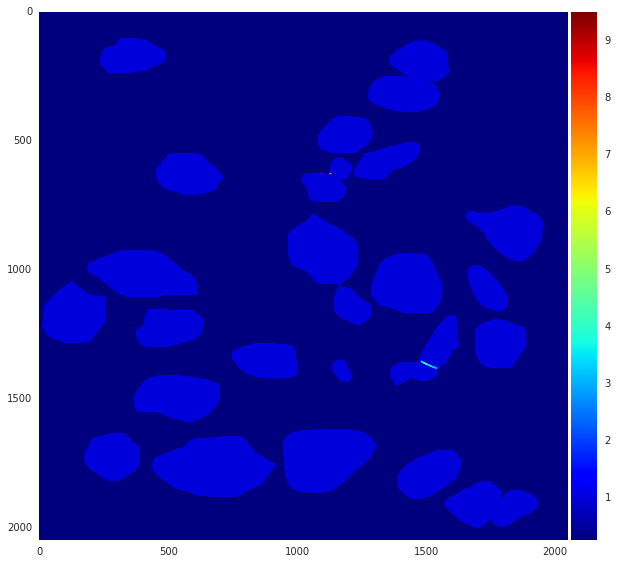

In [8]:
show_fig(get_weight_array('./data/example_cell_label_1.png'), cmap='jet')

Notice that there is not as much weights in this image. This is because the distance between the cells are pretty substantial, and the image size is 5 times bigger than the above one.
Lets adjust sigma such that it has 5x more power.

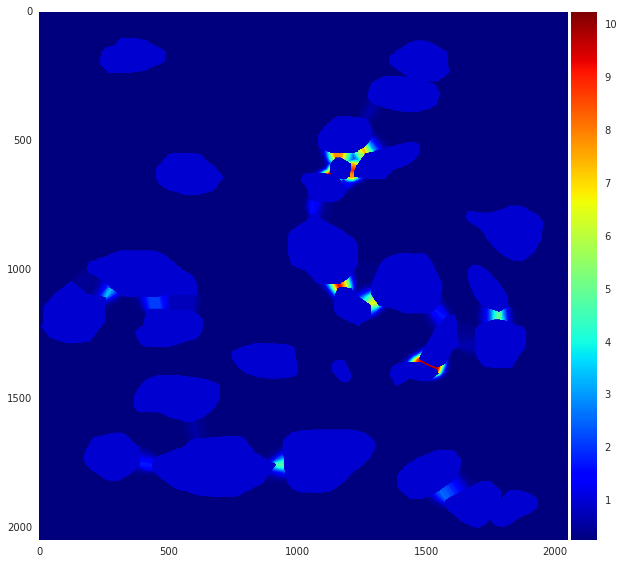

In [12]:
show_fig(get_weight_array('./data/example_cell_label_1.png', sigma=25), cmap='jet')

Better! In the future, it is probably a good idea to include the "boarders" between the cell more clearly.